In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import statsmodels.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as st 
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from keras.layers.core import Dense 
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.core import Activation
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Apps\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.
C:\Apps\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Apps\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Apps\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'
os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ['TF_CUDNN_USE_AUTOTUNE']='0'

import tensorflow as tf
import random

np.random.seed(0)
tf.random.set_random_seed(0)
random.seed(0)

In [3]:
data = pd.read_csv('Covid_19_train.csv')      
data.head()

,Time,Daily_cases
0,2020-02-29,1.0
1,2020-03-01,9.0
2,2020-03-02,3.0
3,2020-03-03,9.0
4,2020-03-04,16.0


In [4]:
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace = True)
data.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


In [5]:
data_index = data.index

In [6]:
len(data)

205

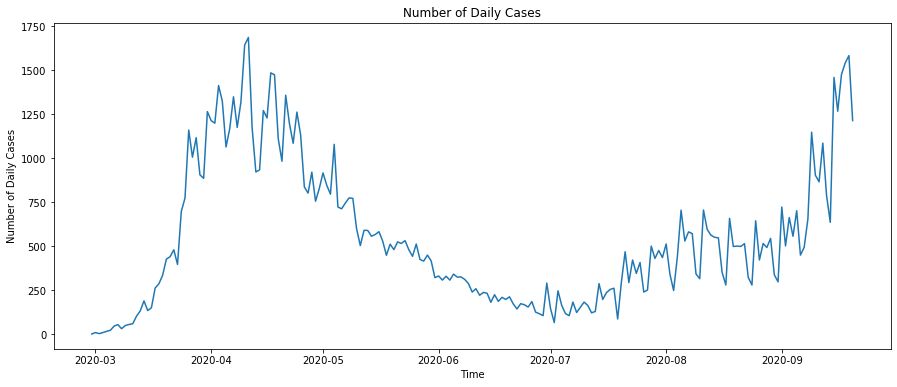

In [7]:
ts = data['Daily_cases']

plt.figure(figsize = (15,6))
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Number of Daily Cases")
plt.show()

In [8]:
accumulated = ts.cumsum()
accumulated

Time
2020-02-29         1.0
2020-03-01        10.0
2020-03-02        13.0
2020-03-03        22.0
2020-03-04        38.0
                ...   
2020-09-16    107353.0
2020-09-17    108828.0
2020-09-18    110368.0
2020-09-19    111950.0
2020-09-20    113163.0
Name: Daily_cases, Length: 205, dtype: float64

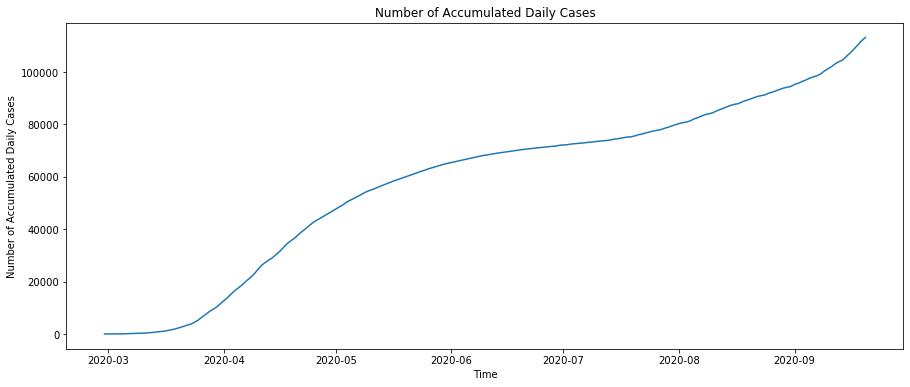

In [9]:
plt.figure(figsize = (15,6))
plt.plot(accumulated)
plt.xlabel('Time')
plt.ylabel('Number of Accumulated Daily Cases')
plt.title("Number of Accumulated Daily Cases")
plt.show()

In [10]:
predictors = ['Daily_cases']

descriptive = data[predictors].describe()
descriptive.loc['var', :] = data.var()
descriptive.loc['kurt', :] = data.kurt()
descriptive.loc['skew', :] = data.skew()
descriptive.round(4)

,Daily_cases
count,205.0000
mean,552.0146
std,403.9527
min,1.0000
25%,239.0000
50%,475.0000
75%,773.0000
max,1685.0000
var,163177.7498
kurt,-0.0785


In [11]:
# Divide the series to train and test data
train = data.iloc[:-15]
validation = data.iloc[-15:]

In [12]:
def mse(forecast, test):
    return ((forecast - test) ** 2).mean()

# MA(7)

In [13]:
rolling_data7 = train.rolling(7,center=True)
print(rolling_data7.mean().head(7))
print(rolling_data7.mean().tail(7))

            Daily_cases
Time                   
2020-02-29          NaN
2020-03-01          NaN
2020-03-02          NaN
2020-03-03    15.142857
2020-03-04    22.714286
2020-03-05    25.857143
2020-03-06    32.428571
            Daily_cases
Time                   
2020-08-30   486.857143
2020-08-31   507.857143
2020-09-01   517.000000
2020-09-02   539.428571
2020-09-03          NaN
2020-09-04          NaN
2020-09-05          NaN


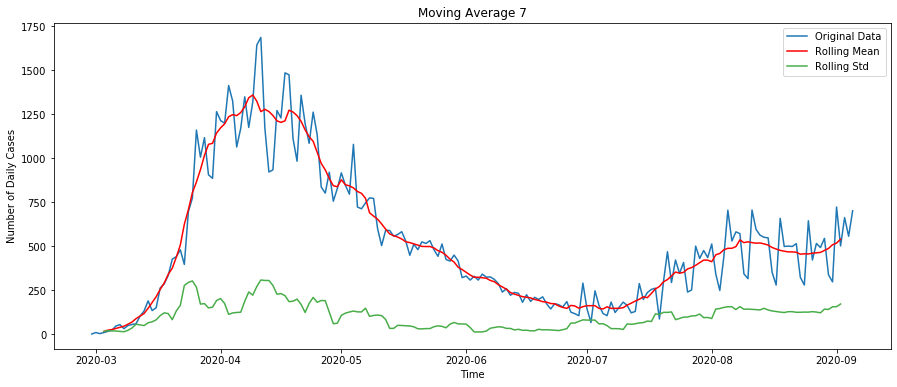

In [14]:
plt.figure(figsize = (15,6))
plt.plot(train,c='C0',label="Original Data")
plt.plot(rolling_data7.mean(),color = 'r',label="Rolling Mean")
plt.plot(rolling_data7.std(),c='#48ad48',label="Rolling Std")
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Moving Average 7")
plt.legend()
plt.show()

# 1. Drift

In [15]:
ts_train = train['Daily_cases']

y_t = ts_train[-1] # last y

y_1 = ts_train[0] # first y

m = (y_t - y_1) / (len(train)-1) # slope

drift_df = validation.copy()
h = np.linspace(1, len(drift_df), len(drift_df))

drift_df['Drift Forecast'] = y_t + h * m
drift_df.head()

,Daily_cases,Drift Forecast
Time,,
2020-09-06,449.0,704.703704
2020-09-07,493.0,708.407407
2020-09-08,654.0,712.111111
2020-09-09,1147.0,715.814815
2020-09-10,903.0,719.518519


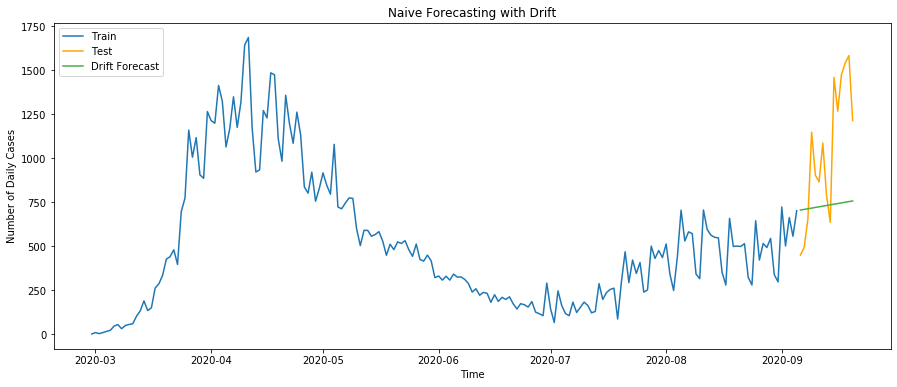

In [16]:
plt.figure(figsize=(15,6))
plt.plot(train.index, train['Daily_cases'], c='C0', label='Train')
plt.plot(validation.index, validation['Daily_cases'], c='orange', label='Test')
plt.plot(validation.index, drift_df['Drift Forecast'], c='#48ad48', label='Drift Forecast')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Naive Forecasting with Drift")
plt.show()

In [17]:
forecast_drift = drift_df['Drift Forecast']
test = validation['Daily_cases']

MSE_drift = mse(forecast_drift, test)

print("MSE of Drift: {:.4f}".format(MSE_drift))

MSE of Drift: 222862.9858


# 2. Seasonal Naive

In [19]:
len(train)%7

1

In [20]:
seasonal_naive = train['Daily_cases'][-7:].tolist()
seasonal_naive = seasonal_naive*3
seasonal_naive = seasonal_naive[:-6]
seasonal_naive

[337.0,
 297.0,
 722.0,
 501.0,
 662.0,
 556.0,
 701.0,
 337.0,
 297.0,
 722.0,
 501.0,
 662.0,
 556.0,
 701.0,
 337.0]

In [21]:
len(seasonal_naive)

15

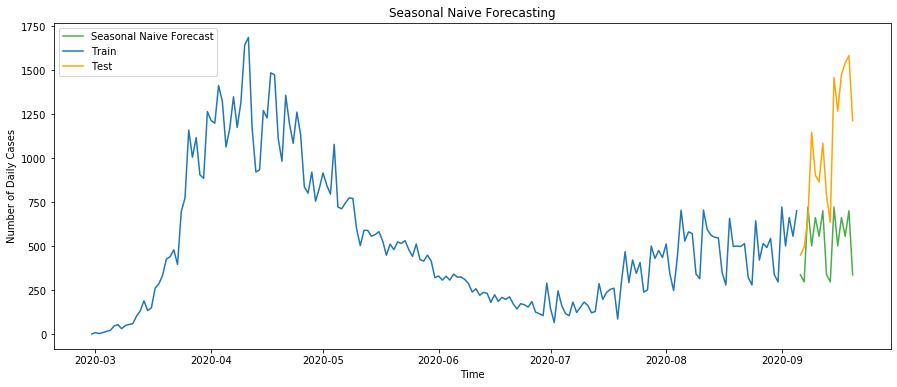

In [22]:
plt.figure(figsize=(15,6))
plt.plot(train.index, train['Daily_cases'], c='C0', label='Train')
plt.plot(validation.index, validation['Daily_cases'], c='orange', label='Test')
plt.plot(validation.index, seasonal_naive, c='#48ad48', label='Seasonal Naive Forecast')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Seasonal Naive Forecasting")
plt.show()

In [23]:
test = validation['Daily_cases']

MSE_seasonal_naive = mse(seasonal_naive, test)

print("MSE of Seasonal Naive: {:.4f}".format(MSE_seasonal_naive))

MSE of Seasonal Naive: 359416.4000


# 3. Holt-Winters Smoothing (Multiplicative)

In [24]:
ts_train = train['Daily_cases']

fit_add = ExponentialSmoothing(ts_train, seasonal_periods=7, trend='add', seasonal='add').fit() # Holt-Winters additive smoothing
fit_add.params

{'smoothing_level': 0.28215543398281784,
 'smoothing_slope': 0.1724408561857998,
 'smoothing_seasonal': 0.3566889475212106,
 'damping_slope': nan,
 'initial_level': 551.8882360622622,
 'initial_slope': 5.718102595125956,
 'initial_seasons': array([-550.88833975, -603.7231787 , -601.53427062, -533.60755125,
        -542.48682789, -516.71491931, -518.84811287]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [25]:
fit_mul = ExponentialSmoothing(ts_train, seasonal_periods=7, trend='add', seasonal='mul').fit() # Holt-Winters multiplicative smoothing
fit_mul.params

{'smoothing_level': 0.36630295072443403,
 'smoothing_slope': 0.15101832083163133,
 'smoothing_seasonal': 0.13245782068052084,
 'damping_slope': nan,
 'initial_level': 565.7497112861781,
 'initial_slope': 7.671712924235423,
 'initial_seasons': array([0.00622585, 0.00236009, 0.00508663, 0.00475105, 0.00455958,
        0.00458687, 0.00548512]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [26]:
# symbol r $ and \ in the results variable are the latex symbols for visualization in notebook
results = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "MSE"])

# ExponentialSmoothing() object has following attributes
params = ['smoothing_level', \
          'smoothing_slope', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_slope']

# check out the performance of additive and multiplicative
results["Additive"]       = [fit_add.params[p] for p in params] + [mse(fit_add.fittedvalues,ts_train)]
results["Multiplicative"] = [fit_mul.params[p] for p in params] + [mse(fit_mul.fittedvalues,ts_train)]

results.round(4)
# 选MSE小的
# Multiplicative更好

,Additive,Multiplicative
$\alpha$,0.2822,0.3663
$\beta$,0.1724,0.1510
$\gamma$,0.3567,0.1325
$l_0$,551.8882,565.7497
$b_0$,5.7181,7.6717
MSE,13156.5230,9875.8726


In [27]:
# use mulplicative to forecast
forecast_mul = fit_mul.forecast(15)
test = validation['Daily_cases']

MSE_mul = mse(forecast_mul, test)

print("MSE of Multiplicative Forecast: {:.4f}".format(MSE_mul))

MSE of Multiplicative Forecast: 181720.8473


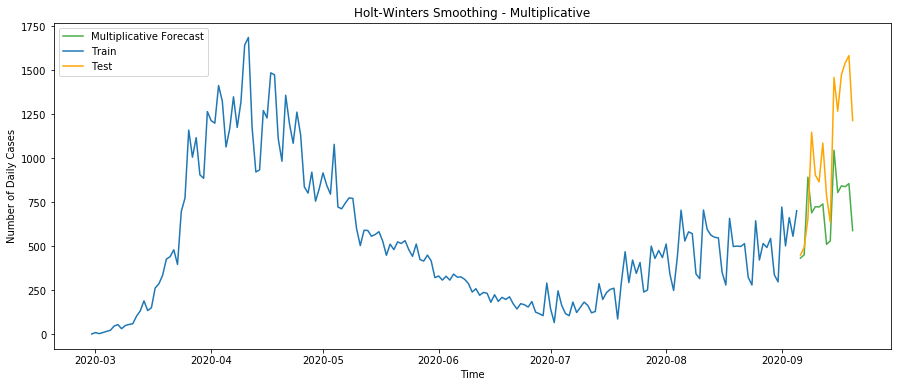

In [28]:
plt.figure(figsize=(15,6))
plt.plot(train.index, train['Daily_cases'], c='C0', label='Train')
plt.plot(validation.index, validation['Daily_cases'], c='orange', label='Test')
plt.plot(validation.index, forecast_mul, c='#48ad48', label='Multiplicative Forecast')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Holt-Winters Smoothing - Multiplicative")
plt.show()

# 4. Seasonal ARIMA

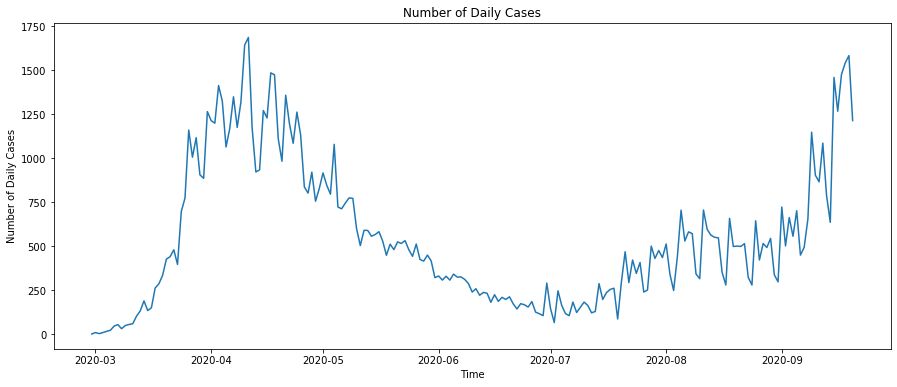

In [29]:
ts = data['Daily_cases']

plt.figure(figsize = (15,6))
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Number of Daily Cases")
plt.show()

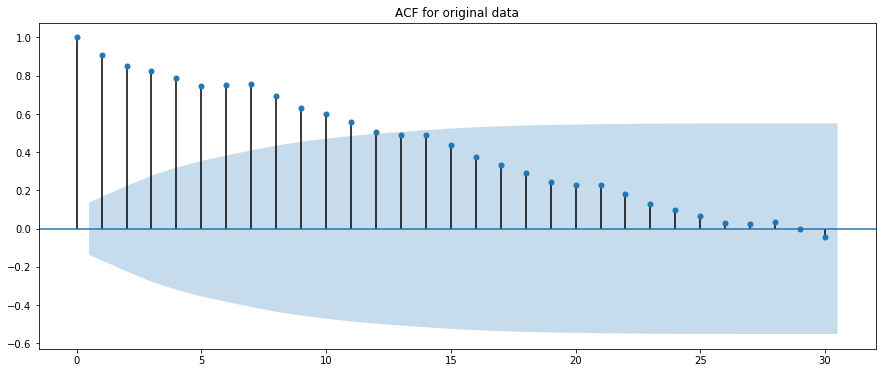

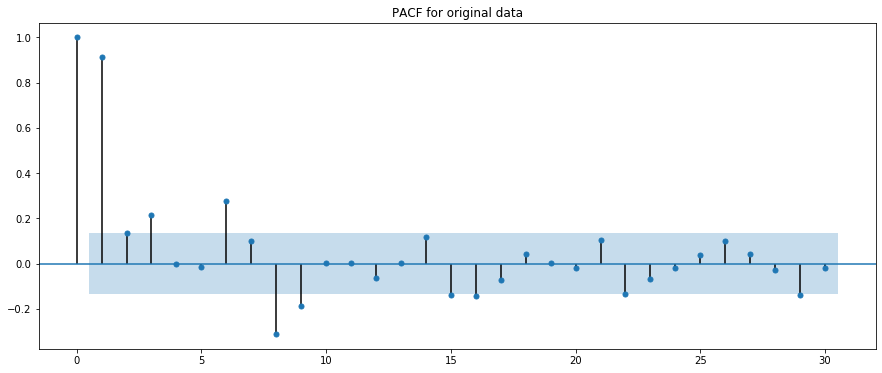

In [30]:
plt.rcParams['figure.figsize'] = (15,6)
smt.graphics.tsa.plot_acf(ts, lags=30, alpha = 0.05,title='ACF for original data')
smt.graphics.tsa.plot_pacf(ts, lags=30, alpha = 0.05,title='PACF for original data')
plt.show()

# log

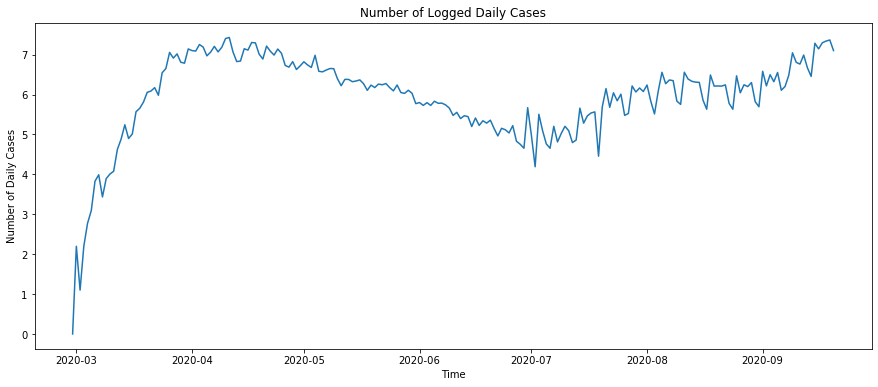

In [31]:
ts_log = np.log(ts)

plt.figure(figsize = (15,6))
plt.plot(ts_log)
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Number of Logged Daily Cases")
plt.show()

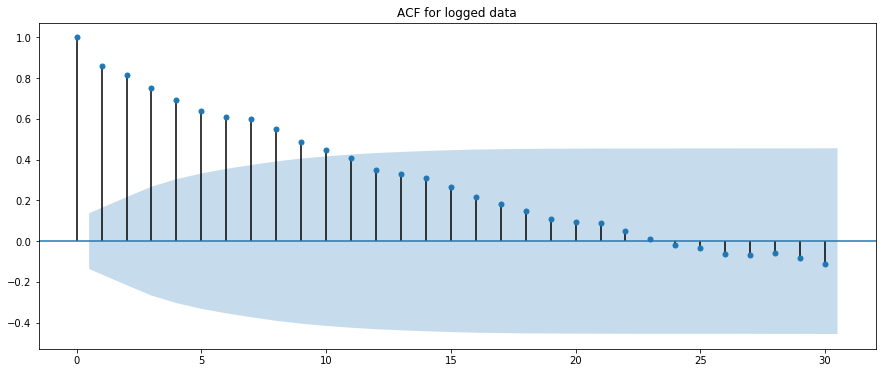

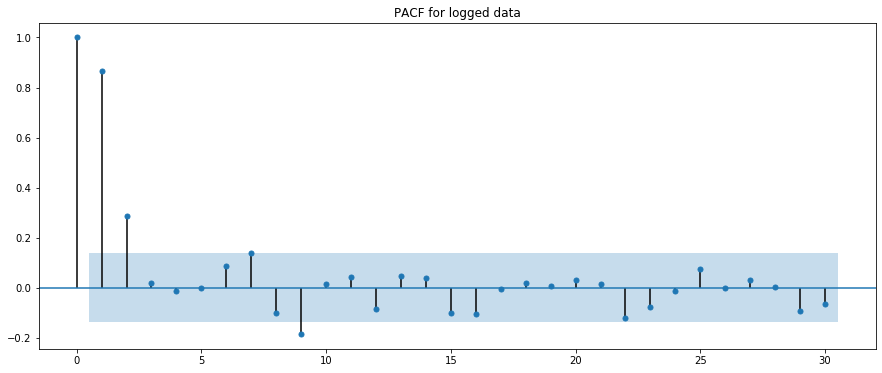

In [32]:
smt.graphics.tsa.plot_acf(ts_log, lags=30, alpha = 0.05,title='ACF for logged data')
smt.graphics.tsa.plot_pacf(ts_log, lags=30, alpha = 0.05,title='PACF for logged data')
plt.show()

# log, d=1

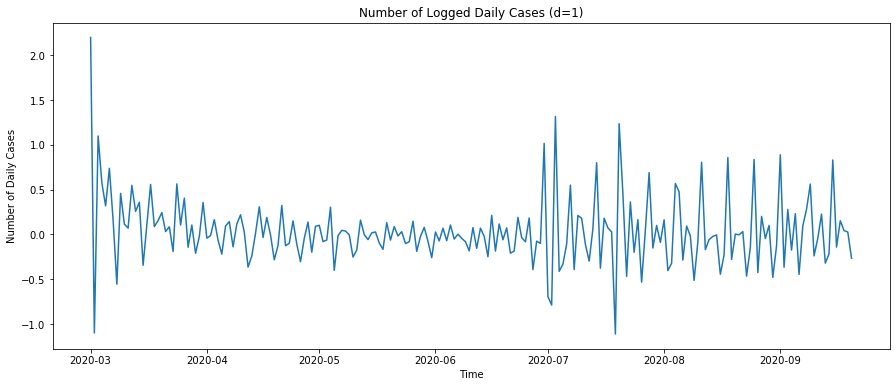

In [33]:
# d=1 for log
ts_log_d = ts_log - ts_log.shift()
ts_log_d.dropna(inplace=True)

plt.figure(figsize = (15,6))
plt.plot(ts_log_d)
plt.title("Number of Logged Daily Cases (d=1)")
plt.ylabel('Number of Daily Cases')
plt.xlabel('Time')
plt.show()

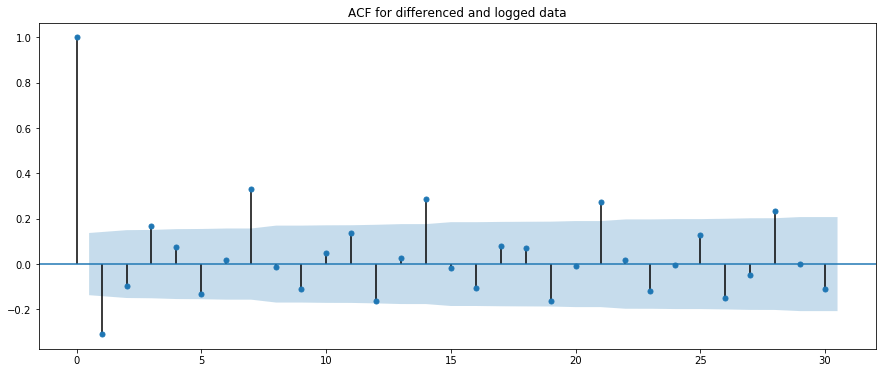

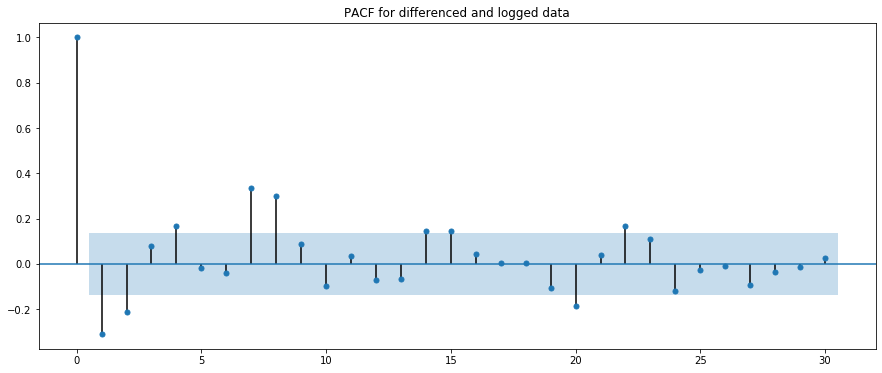

In [34]:
smt.graphics.tsa.plot_acf(ts_log_d, lags=30, alpha = 0.05,title='ACF for differenced and logged data')
smt.graphics.tsa.plot_pacf(ts_log_d, lags=30, alpha = 0.05,title='PACF for differenced and logged data')
plt.show()
# m=7
# D=0 since unstable seasonal pattern over time
# at m=7, ACF>0 --> Q=0
# at m=7, PACF>0 --> P=1
# p,q=(1,4)

## Rules for SARIMA model selection from ACF/PACF plots

These are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA$(p,d,q)(P,D,Q)_m$. The following rules also apply to ARMA$(p,q)$ and ARIMA$(p,d,q)$ models.

### 1. Identifying the order of differencing

- $d = 0$: if the series has no visible trend or ACF at all lags is low.
- $d \ge 1$: if the series has visible trend or positive ACF values out to a high number of lags.

**Note 1:** if after applying differencing to the series and the ACF at lag $1$ is $-0.5$ or more negative the series may be over-differenced.

**Note 2:** If you find the best d to be $d=1$ then the original series has a constant trend. A model with $d=2$ assumes that the original series has a time-varying trend.

### 2. Identifying the number of AR and MA terms

- $p$ is equal to the last lag where the PACF value is above the significance level.
- $q$ is equal to the last lag where the ACF value is above the significance level.

### 3. Identifying the seasonal part of the model

- $m$ is equal to the ACF lag with the highest value (typically at a high lag).
- $D = 1$ if the series has a stable seasonal pattern over time.
- $D = 0$ if the series has an unstable seasonal pattern over time.
- $P ≥ 1$ if the PACF is positive at lag $m$, else $P = 0$.
- $Q ≥ 1$ if the ACF is negative at lag $m$, else $Q = 0$.

**Note 3:** In most cases, $ d + D \le 2$

**Note 4:** In most cases, $ P + Q \le 2$

In [35]:
# AIC
# p,q search 1-4
order = st.arma_order_select_ic(ts_log_d,max_ar=4,max_ma=4,ic=['aic'])
print(order.aic_min_order)  # (p,q)

(4, 4)


In [36]:
train_log = ts_log.iloc[:-15]
validation_log = ts_log.iloc[-15:]

In [37]:
# SARIMA(4,1,4)(1,0,0)7
model = SARIMAX(train_log, 
                order = (4,1,4),                 # Non-seasonal component
                seasonal_order = (1,0,0,7),      # Seasonal component
                enforce_stationarity = False,
                enforce_invertibility = False)

# Fit the SARIMAX model on in-sample data
SARIMA_model = model.fit(disp=-1)

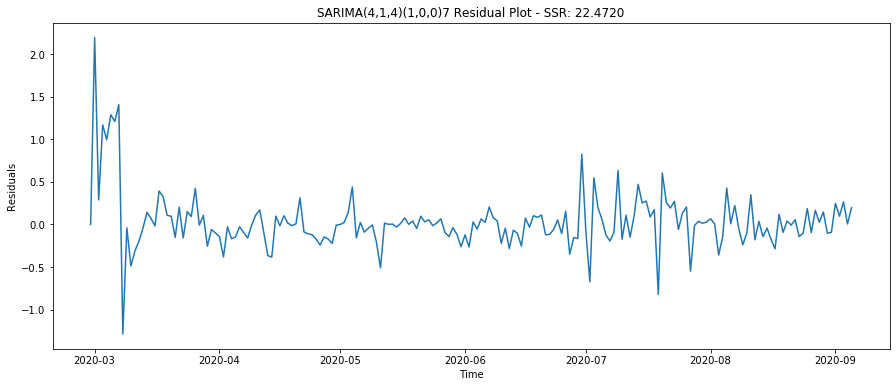

In [38]:
# residual plot
residuals = pd.DataFrame(SARIMA_model.resid)

# Plot residual and calculate sum of squared residual (SSR)
plt.figure()
plt.plot(residuals)
plt.ylabel('Residuals')
plt.xlabel('Time')
plt.title('SARIMA(4,1,4)(1,0,0)7 Residual Plot - SSR: %.4f'% sum((SARIMA_model.resid.values)**2))
plt.show()

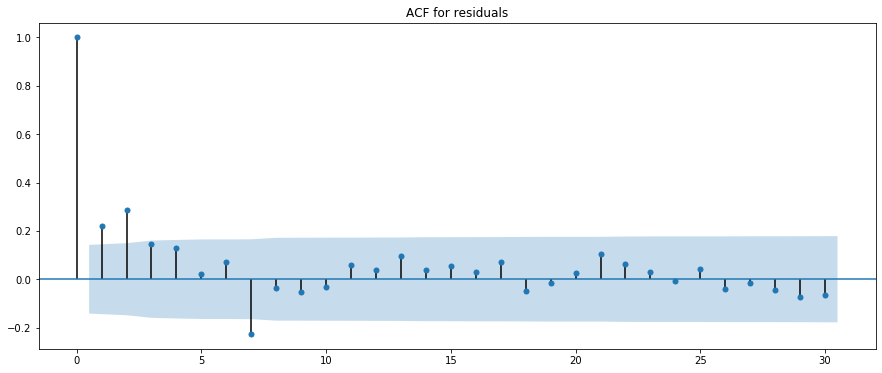

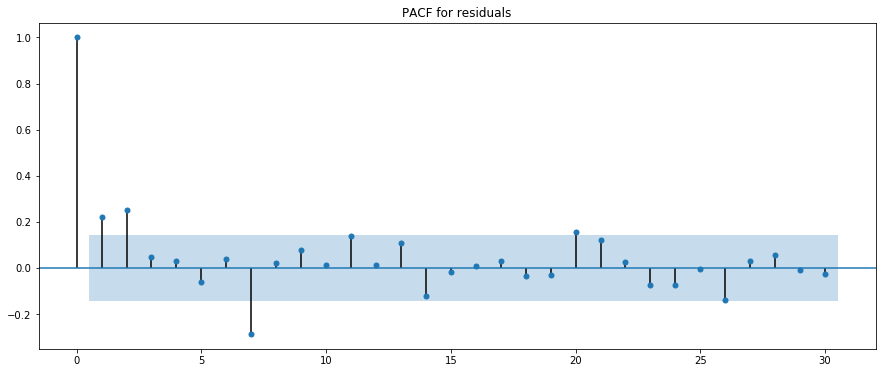

In [39]:
smt.graphics.tsa.plot_acf(SARIMA_model.resid.values, lags=30, alpha = 0.05,title='ACF for residuals')
smt.graphics.tsa.plot_pacf(SARIMA_model.resid.values, lags=30, alpha = 0.05,title='PACF for residuals')
plt.show()

In [40]:
forecast_SARIMA = SARIMA_model.forecast(len(validation))
test = validation_log

MSE_SARIMA = mse(np.exp(forecast_SARIMA), np.exp(test))

print("MSE of SARIMA: {:.4f}".format(MSE_SARIMA))

MSE of SARIMA: 233428.8701


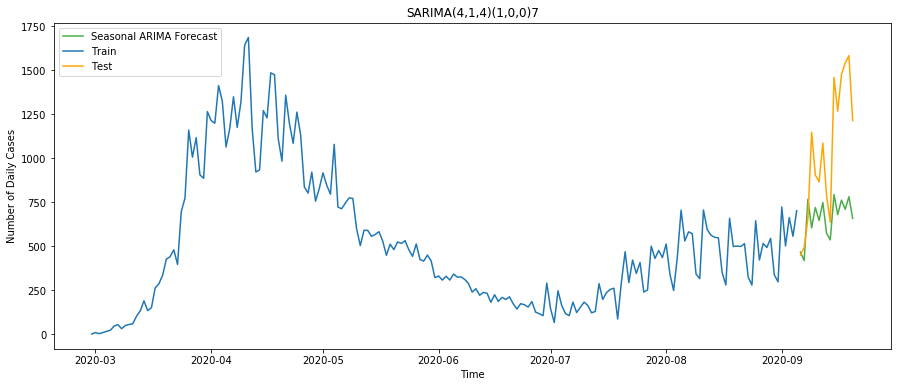

In [41]:
plt.figure(figsize=(15,6))
plt.plot(np.exp(forecast_SARIMA), c='#48ad48', label='Seasonal ARIMA Forecast')
plt.plot(np.exp(train_log), c='C0', label='Train')
plt.plot(np.exp(validation_log), c='orange', label='Test')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("SARIMA(4,1,4)(1,0,0)7")
plt.show()

# 5. Feed Forward Neural Networks (FNN)

In [42]:
data_not_scaled = data.values  # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float') # You need to make sure the data is type of float

In [43]:
# Time window to define the number of features in each row
# SARIMA(4,1,4)(1,0,0)7
# p + P*m = 4+1*7 = 11 NNAR(p,k)
time_window = 11

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

In [44]:
# Compute in-sample and out-of-sample size
# number of columns is time_window
train_size = int((len(data_not_scaled) - time_window) - 15)  # number of rows in the table
test_size = 15

In [45]:
train_size

179

In [46]:
# Fitting the scaler using train set
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data = fitted_transformer.transform(data_not_scaled)
data

array([[0.        ],
       [0.00475059],
       [0.00118765],
       [0.00475059],
       [0.00890736],
       [0.01247031],
       [0.02672209],
       [0.03147268],
       [0.01781473],
       [0.02850356],
       [0.03206651],
       [0.03444181],
       [0.05997625],
       [0.07779097],
       [0.11163895],
       [0.07897862],
       [0.08847981],
       [0.15498812],
       [0.1692399 ],
       [0.19774347],
       [0.2523753 ],
       [0.26068884],
       [0.28384798],
       [0.23456057],
       [0.41270784],
       [0.4584323 ],
       [0.68764846],
       [0.59619952],
       [0.66211401],
       [0.5368171 ],
       [0.52494062],
       [0.75      ],
       [0.71971496],
       [0.7108076 ],
       [0.83788599],
       [0.78562945],
       [0.63064133],
       [0.69299287],
       [0.79988124],
       [0.69655582],
       [0.78266033],
       [0.97446556],
       [1.        ],
       [0.69477435],
       [0.54631829],
       [0.55344418],
       [0.75356295],
       [0.728

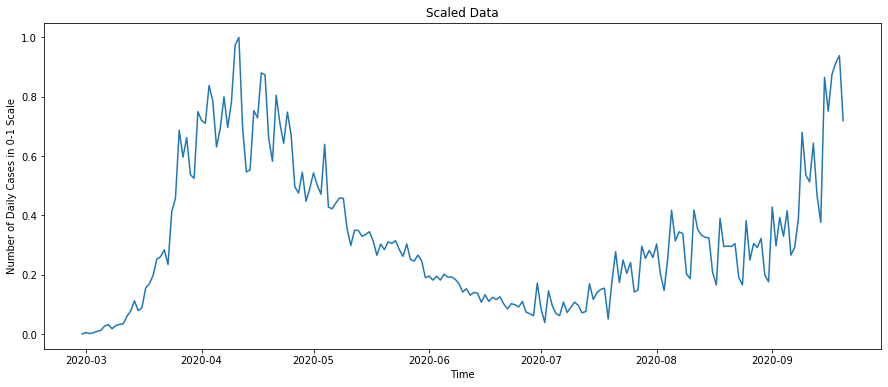

In [47]:
# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(data_index, data)
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases in 0-1 Scale')
plt.title('Scaled Data')
plt.show()

In [48]:
# Pre-allocation
Xall, Yall = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])

#     y从第(time_window+1)个开始, y12, y13...
    Yall.append(data[i, 0])

In [49]:
pd.DataFrame(Xall).head(15)

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.004751,0.001188,0.004751,0.008907,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067
1,0.004751,0.001188,0.004751,0.008907,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442
2,0.001188,0.004751,0.008907,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976
3,0.004751,0.008907,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791
4,0.008907,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639
5,0.012470,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639,0.078979
6,0.026722,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639,0.078979,0.088480
7,0.031473,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639,0.078979,0.088480,0.154988
8,0.017815,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639,0.078979,0.088480,0.154988,0.169240
9,0.028504,0.032067,0.034442,0.059976,0.077791,0.111639,0.078979,0.088480,0.154988,0.169240,0.197743


In [50]:
Yall

[0.0344418052256532,
 0.05997624703087886,
 0.07779097387173396,
 0.11163895486935867,
 0.07897862232779097,
 0.08847980997624703,
 0.15498812351543945,
 0.16923990498812352,
 0.1977434679334917,
 0.252375296912114,
 0.2606888361045131,
 0.2838479809976247,
 0.2345605700712589,
 0.41270783847981,
 0.4584323040380048,
 0.6876484560570072,
 0.5961995249406177,
 0.6621140142517815,
 0.5368171021377673,
 0.5249406175771972,
 0.7500000000000001,
 0.7197149643705464,
 0.7108076009501189,
 0.8378859857482186,
 0.7856294536817103,
 0.6306413301662709,
 0.6929928741092637,
 0.7998812351543944,
 0.6965558194774347,
 0.7826603325415677,
 0.9744655581947744,
 1.0,
 0.6947743467933493,
 0.5463182897862233,
 0.5534441805225654,
 0.7535629453681711,
 0.7286223277909739,
 0.8806413301662709,
 0.8741092636579574,
 0.6585510688836105,
 0.5825415676959621,
 0.805225653206651,
 0.7096199524940618,
 0.6431116389548694,
 0.7482185273159145,
 0.6716152019002376,
 0.4958432304038005,
 0.4750593824228029,
 0.5

In [51]:
# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)

In [52]:
# Training data
Xtrain = Xall[:train_size,:]
Ytrain = Yall[:train_size]

# Test data
Xtest = Xall[-test_size:,:]
Ytest = Yall[-test_size:]

In [53]:
print(Xall.shape)
print(Yall.shape)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(194, 11)
(194,)
(179, 11)
(179,)
(15, 11)
(15,)


# Hyper Parameter Optimisation -- Manually

In [54]:
# build the optimized model
# a one-hidden layer model
# our input gets sent to a layer of 20 neurons then output through a dense layer that combines the output of all 20 neurons
# input_dim -- dimentionality of the input in the first hidden layer
model = Sequential()
model.add(Dense(20, input_dim = time_window, activation='relu'))  # Rectified Linear Unit
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSprop')

# verbose=1 -- print out the process
model.fit(Xtrain, Ytrain, batch_size=16, epochs=100, verbose=2)







Epoch 1/100
 - 0s - loss: 0.0189
Epoch 2/100
 - 0s - loss: 0.0157
Epoch 3/100
 - 0s - loss: 0.0143
Epoch 4/100
 - 0s - loss: 0.0134
Epoch 5/100
 - 0s - loss: 0.0122
Epoch 6/100
 - 0s - loss: 0.0115
Epoch 7/100
 - 0s - loss: 0.0113
Epoch 8/100
 - 0s - loss: 0.0105
Epoch 9/100
 - 0s - loss: 0.0098
Epoch 10/100
 - 0s - loss: 0.0097
Epoch 11/100
 - 0s - loss: 0.0091
Epoch 12/100
 - 0s - loss: 0.0087
Epoch 13/100
 - 0s - loss: 0.0085
Epoch 14/100
 - 0s - loss: 0.0082
Epoch 15/100
 - 0s - loss: 0.0078
Epoch 16/100
 - 0s - loss: 0.0077
Epoch 17/100
 - 0s - loss: 0.0078
Epoch 18/100
 - 0s - loss: 0.0072
Epoch 19/100
 - 0s - loss: 0.0068
Epoch 20/100
 - 0s - loss: 0.0070
Epoch 21/100
 - 0s - loss: 0.0067
Epoch 22/100
 - 0s - loss: 0.0063
Epoch 23/100
 - 0s - loss: 0.0063
Epoch 24/100
 - 0s - loss: 0.0062
Epoch 25/100
 - 0s - loss: 0.0062
Epoch 26/100
 - 0s - loss: 0.0062
Epoch 27/100
 - 0s - loss: 0.0058
Epoch 28/100
 - 0s - loss: 0.0061
Epoch 29/100
 - 0s - loss: 0.0057
Epoch 30/100
 - 0

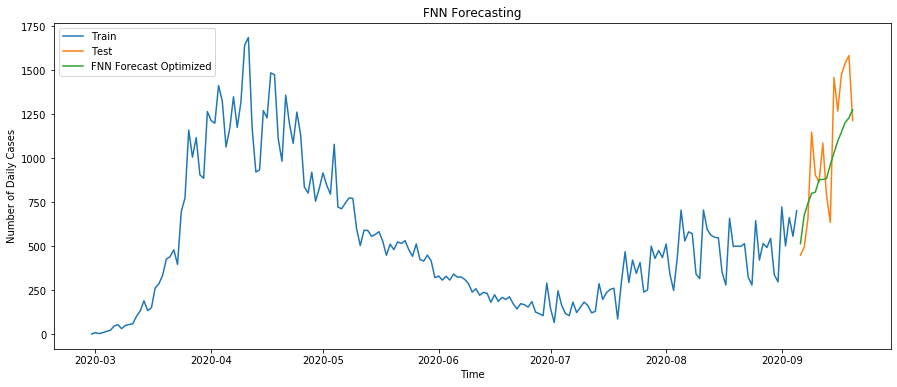

In [55]:
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

dynamic_prediction = dynamic_prediction.reshape(-1,1)

# Transform forecast values to original scale
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

# Plot forecast and test values
train_index = np.arange(0, len(data) - test_size, 1)  # len=190
test_index = np.arange(len(data) - test_size, len(data), 1)  # len=15

plt.figure(figsize=(15,6))
plt.plot(data_index[train_index], scaler.inverse_transform(data[:len(data) - test_size]), label='Train')
plt.plot(data_index[test_index], scaler.inverse_transform(data[-test_size:]), label='Test')
plt.plot(data_index[test_index], dynamic_prediction[-test_size:], label='FNN Forecast Optimized')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("FNN Forecasting")
plt.legend(loc = "upper left")
plt.show()

In [56]:
forecast_FNN_optimazied = dynamic_prediction[-test_size:].ravel()
test = validation['Daily_cases']

MSE_FNN_optimazied = mse(forecast_FNN_optimazied, test)

print("MSE of FNN: {:.4f}".format(MSE_FNN_optimazied))

MSE of FNN: 59763.6339


# 6. Forecast Combination

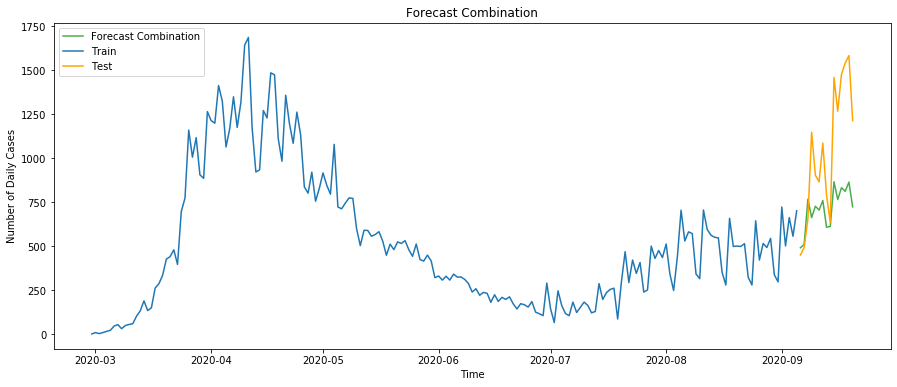

In [57]:
forecast_combination = np.mean([forecast_drift, seasonal_naive, forecast_mul, np.exp(forecast_SARIMA), forecast_FNN_optimazied],axis=0)

plt.figure(figsize=(15,6))
plt.plot(validation.index, forecast_combination, c='#48ad48', label='Forecast Combination')
plt.plot(train.index, train['Daily_cases'], c='C0', label='Train')
plt.plot(validation.index, validation['Daily_cases'], c='orange', label='Test')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Forecast Combination")
plt.show()

In [58]:
test = validation['Daily_cases']

MSE_Combination = mse(forecast_combination, test)

print("MSE of Forecast Combination: {:.4f}".format(MSE_Combination))

MSE of Forecast Combination: 183396.6725


# Model Evaluation

In [59]:
results = pd.DataFrame({"Model": ['Drift', 'Seasonal Naive', 'Holt-Winters Smoothing (Multiplicative)', 'Seasonal ARIMA', 'FNN', 'Forecast Combination'],
                     "MSE": [MSE_drift, MSE_seasonal_naive, MSE_mul, MSE_SARIMA, MSE_FNN_optimazied, MSE_Combination]})

results.sort_values('MSE').round(4)

,Model,MSE
4,FNN,59763.6339
2,Holt-Winters Smoothing (Multiplicative),181720.8473
5,Forecast Combination,183396.6725
0,Drift,222862.9858
3,Seasonal ARIMA,233428.8701
1,Seasonal Naive,359416.4000


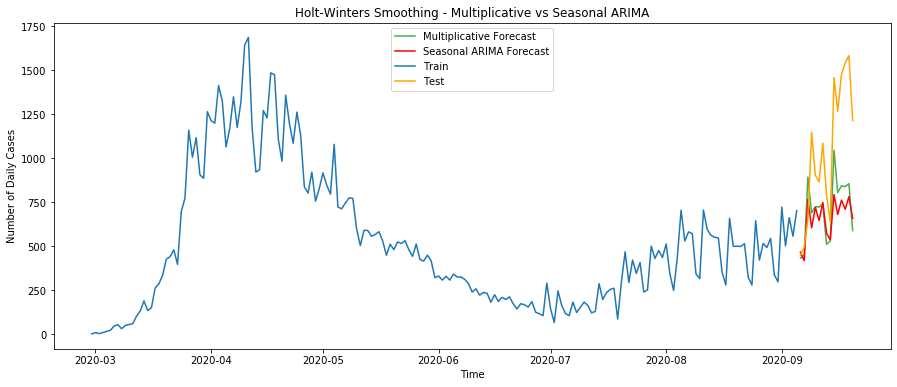

In [60]:
plt.figure(figsize=(15,6))
plt.plot(validation.index, forecast_mul, c='#48ad48', label='Multiplicative Forecast')
plt.plot(np.exp(forecast_SARIMA),'-r',label='Seasonal ARIMA Forecast')
plt.plot(train.index, train['Daily_cases'], c='C0', label='Train')
plt.plot(validation.index, validation['Daily_cases'], c='orange', label='Test')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("Holt-Winters Smoothing - Multiplicative vs Seasonal ARIMA")
plt.show()

# Forecast

In [81]:
data = pd.read_csv('Covid_19_train.csv')      
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace = True)
data.head()

,Daily_cases
Time,
2020-02-29,1.0
2020-03-01,9.0
2020-03-02,3.0
2020-03-03,9.0
2020-03-04,16.0


In [82]:
data.shape

(205, 1)

In [62]:
covid_19_test = pd.read_csv('Covid_19_test.csv')  
test = covid_19_test.copy()
test.head()

,Time,Daily_cases
0,21/09/2020,1
1,22/09/2020,2
2,23/09/2020,3
3,24/09/2020,4
4,25/09/2020,5


In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time         15 non-null     object
 1   Daily_cases  15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 368.0+ bytes


In [64]:
test['Daily_cases'] = test['Daily_cases'].astype('float')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         15 non-null     object 
 1   Daily_cases  15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes


In [65]:
test['Time'] = pd.to_datetime(test['Time'], format ='%d/%m/%Y')
test.set_index('Time', inplace = True)
test

,Daily_cases
Time,
2020-09-21,1.0
2020-09-22,2.0
2020-09-23,3.0
2020-09-24,4.0
2020-09-25,5.0
2020-09-26,6.0
2020-09-27,7.0
2020-09-28,8.0
2020-09-29,9.0


In [66]:
len(test)

15

# 5. Feed Forward Neural Networks (FNN)

In [67]:
len(data)

205

In [68]:
# Time window to define the number of features in each row
# SARIMA(4,1,4)(1,0,0)7
# p + P*m = 4+1*7 = 11
time_window = 11

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

In [83]:
data_not_scaled.shape

(205, 1)

In [69]:
# Compute in-sample and out-of-sample size
# number of columns is time_window
train_size = int((len(data_not_scaled) - time_window))  # number of rows in the table
test_size = 15

In [70]:
train_size

194

In [71]:
# Fitting the scaler using train set
fitted_transformer = scaler.fit(data[:train_size+time_window])

# Transforming using trained scaler
data = fitted_transformer.transform(data)
data

array([[0.        ],
       [0.00475059],
       [0.00118765],
       [0.00475059],
       [0.00890736],
       [0.01247031],
       [0.02672209],
       [0.03147268],
       [0.01781473],
       [0.02850356],
       [0.03206651],
       [0.03444181],
       [0.05997625],
       [0.07779097],
       [0.11163895],
       [0.07897862],
       [0.08847981],
       [0.15498812],
       [0.1692399 ],
       [0.19774347],
       [0.2523753 ],
       [0.26068884],
       [0.28384798],
       [0.23456057],
       [0.41270784],
       [0.4584323 ],
       [0.68764846],
       [0.59619952],
       [0.66211401],
       [0.5368171 ],
       [0.52494062],
       [0.75      ],
       [0.71971496],
       [0.7108076 ],
       [0.83788599],
       [0.78562945],
       [0.63064133],
       [0.69299287],
       [0.79988124],
       [0.69655582],
       [0.78266033],
       [0.97446556],
       [1.        ],
       [0.69477435],
       [0.54631829],
       [0.55344418],
       [0.75356295],
       [0.728

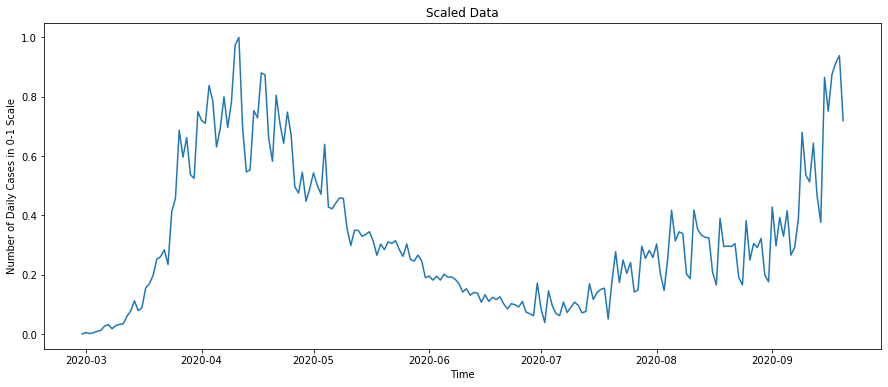

In [72]:
# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(data_index, data)
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases in 0-1 Scale')
plt.title('Scaled Data')
plt.show()

In [73]:
# Pre-allocation
Xall, Yall = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])

#     y从第(time_window+1)个开始, y12, y13...
    Yall.append(data[i, 0])

In [74]:
# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)

In [75]:
import os
os.environ['PYTHONHASHSEED']='0'
os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ['TF_CUDNN_USE_AUTOTUNE']='0'

import tensorflow as tf
import random

np.random.seed(0)
tf.random.set_random_seed(0)
random.seed(0)

In [76]:
# build the optimized model
# a one-hidden layer model
# our input gets sent to a layer of 20 neurons then output through a dense layer that combines the output of all 20 neurons
# input_dim -- dimentionality of the input in the first hidden layer
model = Sequential()
model.add(Dense(20, input_dim = time_window, activation='relu'))  # Rectified Linear Unit
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSprop')

# verbose=1 -- print out the process
model.fit(Xall, Yall, batch_size=16, epochs=100, verbose=2)

Epoch 1/100
 - 0s - loss: 0.0240
Epoch 2/100
 - 0s - loss: 0.0201
Epoch 3/100
 - 0s - loss: 0.0179
Epoch 4/100
 - 0s - loss: 0.0165
Epoch 5/100
 - 0s - loss: 0.0155
Epoch 6/100
 - 0s - loss: 0.0146
Epoch 7/100
 - 0s - loss: 0.0139
Epoch 8/100
 - 0s - loss: 0.0129
Epoch 9/100
 - 0s - loss: 0.0128
Epoch 10/100
 - 0s - loss: 0.0122
Epoch 11/100
 - 0s - loss: 0.0114
Epoch 12/100
 - 0s - loss: 0.0112
Epoch 13/100
 - 0s - loss: 0.0103
Epoch 14/100
 - 0s - loss: 0.0100
Epoch 15/100
 - 0s - loss: 0.0095
Epoch 16/100
 - 0s - loss: 0.0096
Epoch 17/100
 - 0s - loss: 0.0089
Epoch 18/100
 - 0s - loss: 0.0087
Epoch 19/100
 - 0s - loss: 0.0083
Epoch 20/100
 - 0s - loss: 0.0081
Epoch 21/100
 - 0s - loss: 0.0080
Epoch 22/100
 - 0s - loss: 0.0080
Epoch 23/100
 - 0s - loss: 0.0077
Epoch 24/100
 - 0s - loss: 0.0076
Epoch 25/100
 - 0s - loss: 0.0074
Epoch 26/100
 - 0s - loss: 0.0073
Epoch 27/100
 - 0s - loss: 0.0073
Epoch 28/100
 - 0s - loss: 0.0070
Epoch 29/100
 - 0s - loss: 0.0071
Epoch 30/100
 - 0s - lo

In [77]:
dynamic_prediction = np.copy(data)
len(dynamic_prediction)

205

In [78]:
for i in range(len(data), len(data) + test_size):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
len(dynamic_prediction)

220

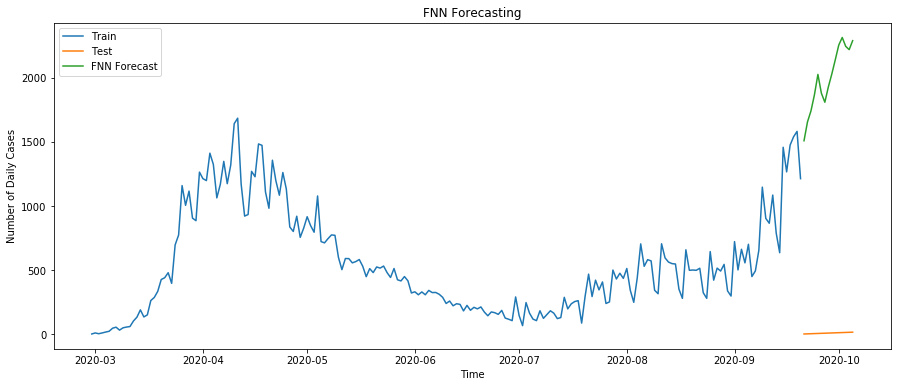

In [79]:
dynamic_prediction = dynamic_prediction.reshape(-1,1)

# Transform forecast values to original scale
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

forecast_FNN_2 = dynamic_prediction[-test_size:].ravel()

# Plot forecast and test values
plt.figure(figsize=(15,6))
plt.plot(data_index, scaler.inverse_transform(data), label='Train')
plt.plot(test.index, test['Daily_cases'], label='Test')
plt.plot(test.index, forecast_FNN_2, label='FNN Forecast')
plt.xlabel('Time')
plt.ylabel('Number of Daily Cases')
plt.title("FNN Forecasting")
plt.legend(loc = "upper left")
plt.show()

In [80]:
forecast_FNN_optimazied = dynamic_prediction[-test_size:].ravel()
test = test['Daily_cases']

MSE_FNN_optimazied = mse(forecast_FNN_optimazied, test)

print("test error: {:.4f}".format(MSE_FNN_optimazied))

test error: 4001985.8930
